- RSI2 - overbought + oversold
- RSI5 + SMA7 crossing / RSI8 + RSI7 crossing for 15min 

In [1]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import glob
import datetime

logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.CRITICAL)

In [ ]:
class Trader:
    def __init__(self, margin=100):
        self.initial_margin = margin
        self.margin = margin
        self.history = []
        self.cache = {
            'entry_price': None,
            'position' : None, # long=1 / short=-1
        }
        
    @property
    def position(self):
        return self.cache['position']
    
    @position.setter
    def position(self, value):
        if (value == 'long') | (value == 'short') | (value == None):
            self.cache['position'] = value
        else:
            raise Exception('Enter long / short')
        
    @property
    def entry_price(self):
        return self.cache['entry_price']
    
    @entry_price.setter
    def entry_price(self, value):
        self.cache['entry_price'] = value
        
    @property
    def exit_price(self):
        return self.cache['exit_price']
        
    def reset(self):
        logging.info('Resetting...')
        self.cache = {
            'entry_price': None,
            'position' : None,
        }
        self.history = []
        self.margin = self.initial_margin
        
    def _clear_cache(self):
        self.cache = {
            'entry_price': None,
            'position' : None,
        }
        
    def open_pos(self, price, position, **kwargs):
        if self.position == None:
            self.entry_price = price
            self.position = position
            self._update_cache(**kwargs)
            logging.info('Enter {position} - price : {price}'.format(position=self.position, price=price))
        else:
            raise Exception('Has an opening position')

    def close_pos(self, exit_price, **kwargs):
        if (self.position != 'long') & (self.position != 'short'):
            raise Exception('No position')
        else:
            percentage = self.get_percentage(self.entry_price, exit_price, self.position)
            self._update_margin(percentage)
            self._update_cache(exit_price=exit_price, percentage=percentage, margin=self.margin, **kwargs)
            self._append_history()
            self._clear_cache()
            logging.info('Close {position} - price : {price} | percentage : {percentage}'.format(position=self.position, price=exit_price, percentage=percentage))
    
    def get_percentage(self, entry, exit, position):
        if position == 'long':
            return (exit - entry) / entry + 1
        elif position == 'short':
            return (entry - exit) / entry + 1
        else:
            raise Exception('Please enter position')
            
    def _update_margin(self, percentage):
        self.margin = self.margin * percentage 
    
    def _update_cache(self, **kwargs):
        for kwarg in kwargs:
            self.cache[kwarg] = kwargs[kwarg]
    
    def _append_history(self):
        self.history.append(self.cache)

## RSI + SMA

In [ ]:
rsi_range = np.arange(2, 50)
ema_range = np.arange(2, 100)

history = []
trader = Trader()

for r in rsi_range:
    print()
    print('rsi=',r)
    for i, e in enumerate(ema_range):
        print('\rema={:d} | {:.2f}%'.format(e, i / (len(ema_range) + 1) * 100), end='')
        data_paths = [
            'data/february/ethusdt.15min.1-28feb2022.csv',
            'data/march/ethusdt.15min.1march2022-18march2022.csv'
        ]

        df = pd.concat([pd.read_csv(data_path, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for data_path in data_paths])
        df = df.drop_duplicates(keep='first')

        df = df.assign(rsi=talib.RSI(df.Close, timeperiod=r))
        df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=e))
        df = df.dropna()

        df.index = pd.to_datetime(df.index)
        df = df[df.index.month == 3]
        
        trader.reset()

        previous_rsi = df.iloc[0].rsi
        previous_rsiema = df.iloc[0].rsi_ema
        for idx, data in df.iloc[1:].iterrows():
            if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
            elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)

            previous_rsi = data.rsi
            previous_rsiema = data.rsi_ema
        history.append([r, e, trader.margin])
    print('Maximum percentage = ', np.max(np.array(history)[:, 2]))

In [ ]:
tmp = pd.DataFrame(history)
tmp = tmp[tmp[2] > 100]

In [ ]:
tmp[tmp[0] < 10].sort_values(2, ascending=False).head(30)

In [ ]:
tmp.to_json('rsi_strategy.15min_setting.json')

In [ ]:
data_paths = [
    'data/january/ethusdt.15min.1january2022-1february2022.csv',
    'data/february/ethusdt.15min.1-28feb2022.csv',
    'data/march/ethusdt.15min.1march2022-18march2022.csv'
]

df = pd.concat([pd.read_csv(data_path, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for data_path in data_paths])
df = df.drop_duplicates(keep='first')

df = df.assign(rsi=talib.RSI(df.Close, timeperiod=5))
df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=7))
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df[df.index.month >= 2]

In [ ]:
trader = Trader()

previous_rsi = df.iloc[0].rsi
previous_rsiema = df.iloc[0].rsi_ema
for idx, data in df.iloc[1:].iterrows():
    if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
    elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
            
    previous_rsi = data.rsi
    previous_rsiema = data.rsi_ema
    

In [ ]:
result = pd.DataFrame(trader.history).set_index('entry_date')

In [ ]:
result

In [ ]:
win = result[result.percentage > 1]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(result.margin)

In [ ]:
result[result.percentage > 1].percentage.mean()

In [ ]:
result[result.percentage < 1].percentage.mean()

## RSI + EMA

In [ ]:
rsi_range = np.arange(2, 50)
ema_range = np.arange(2, 100)

history = []
trader = Trader()

for r in rsi_range:
    print()
    print('rsi=',r)
    for i, e in enumerate(ema_range):
        print('\rema={:d} | {:.2f}%'.format(e, i / (len(ema_range) + 1) * 100), end='')
        data_paths = [
            'data/february/ethusdt.15min.1-28feb2022.csv',
            'data/march/ethusdt.15min.1march2022-18march2022.csv'
        ]

        df = pd.concat([pd.read_csv(data_path, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for data_path in data_paths])
        df = df.drop_duplicates(keep='first')

        df = df.assign(rsi=talib.RSI(df.Close, timeperiod=r))
        df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=e))
        df = df.dropna()

        df.index = pd.to_datetime(df.index)
        df = df[df.index.month == 3]
        
        trader.reset()

        previous_rsi = df.iloc[0].rsi
        previous_rsiema = df.iloc[0].rsi_ema
        for idx, data in df.iloc[1:].iterrows():
            if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
            elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)

            previous_rsi = data.rsi
            previous_rsiema = data.rsi_ema
        history.append([r, e, trader.margin])
    print('Maximum percentage = ', np.max(np.array(history)[:, 2]))

In [ ]:
tmp_ema = pd.DataFrame(history)
tmp_ema = tmp_ema[tmp_ema[2] > 100]

In [ ]:
tmp_ema.sort_values(2, ascending=False).head(30)

In [ ]:
data_paths = [
    'data/january/ethusdt.15min.1january2022-1february2022.csv',
    'data/february/ethusdt.15min.1-28feb2022.csv',
    'data/march/ethusdt.15min.1march2022-18march2022.csv'
]

df = pd.concat([pd.read_csv(data_path, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for data_path in data_paths])
df = df.drop_duplicates(keep='first')

df = df.assign(rsi=talib.RSI(df.Close, timeperiod=8))
df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=7))
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df[df.index.month >= 2]

trader = Trader()

previous_rsi = df.iloc[0].rsi
previous_rsiema = df.iloc[0].rsi_ema
for idx, data in df.iloc[1:].iterrows():
    if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
    elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
            
    previous_rsi = data.rsi
    previous_rsiema = data.rsi_ema
    

In [ ]:
result

In [ ]:
result = pd.DataFrame(trader.history).set_index('entry_date')

In [ ]:
win = result[result.percentage > 1]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(result.margin)

# Future trade

In [2]:
class Trader:
    def __init__(self, symbol='eth', account_size=100, margin=0.1, fixed_margin=False, leverage=1, fee=0.0004):
        """
        Account size : int
        - Money in the account
        
        Margin : float [0, 1]
        - Percentage of account size for each trade
        
        fixed_margin : bool
        - use fixed margin for each trade
        - True : each trade use initial account size * margin
        - False : each trade use current account size * margin
        
        leverage : int
        
        fee : float
        """
        
        if (margin > 1) or (margin < 0):
            raise Exception('Margin between 0 and 1')
        
        self.symbol = symbol
        self.initial_account_size = account_size
        self._margin = margin
        self.account_size = account_size
        self.leverage = leverage
        self.fixed_margin = fixed_margin
        self.fee = fee
        self.history = []
        self.cache = {
            'entry_price': None,
            'position' : None, # long=1 / short=-1
            'entry_margin' : None
        }
        
    @property
    def margin(self):
        if self.fixed_margin:
            return self.initial_account_size * self._margin
        else:
            return self.account_size * self._margin
        
    @property
    def position(self):
        return self.cache['position']
    
    @position.setter
    def position(self, value):
        if (value == 'long') | (value == 'short') | (value == None):
            self.cache['position'] = value
        else:
            raise Exception('Enter long / short')
        
    @property
    def entry_price(self):
        return self.cache['entry_price']
    
    @entry_price.setter
    def entry_price(self, value):
        self.cache['entry_price'] = value
        
    @property
    def exit_price(self):
        return self.cache['exit_price']
        
    @property
    def entry_margin(self):
        return self.cache['entry_margin']
    
    @entry_margin.setter
    def entry_margin(self, value):
        self.cache['entry_margin'] = value
        
    def reset(self):
        logging.info('Resetting...')
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        self.history = []
        self.account_size = self.initial_account_size
        
    def _clear_cache(self):
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        
    def open_pos(self, price, position, **kwargs):
        """
        1. Get entry price and position
        2. Get other entry information
        3. Compute trade size / notional size (leverage * margin)
        4. Compute Fee (trade size * fee)
        5. Fee reduction
        """
        if self.position != None:
            raise Exception('Has an opening position')
            
        self.entry_price = price
        self.position = position
        self.entry_margin = self.margin
        number_contract = self._compute_number_contract(price)
        fee = self._deduct_fee()
        self._update_cache(entry_fee=fee, number_contract=number_contract, **kwargs)
        logging.info('Enter {position} - price : {price} | size : {size}{symbol}'.format(position=self.position, 
                                                                                         price=price,
                                                                                         size=number_contract,
                                                                                         symbol=self.symbol))

    def close_pos(self, exit_price, **kwargs):
        if (self.position != 'long') & (self.position != 'short'):
            raise Exception('No position')
            
        percentage = self.get_percentage(self.entry_price, exit_price, self.position)
        self._update_account_size(percentage)
        fee = self._deduct_fee()
        self._update_cache(exit_price=exit_price, profit=self.entry_margin * percentage, percentage=percentage, exit_fee=fee, account_size=self.account_size, **kwargs)
        self._append_history()
        logging.info('Close {position} - price : {price} | percentage(%) : {percentage}'.format(position=self.position, 
                                                                                                price=exit_price, 
                                                                                                percentage=percentage*100))
        self._clear_cache()
    
    def get_liquidation_price(self):
        side1both = 1 if self.position == 'long' else -1
        position1both = self.cache['number_contract']
        ep1both = self.entry_price
        mmrb = 0.005
        return (self.account_size - side1both * position1both * ep1both) / (position1both * mmrb - side1both * position1both)
        
    def is_liquidated(self, price):
        if self.position == None:
            raise Exception('No position')
        
        if self.position == 'long':
            return price <= self.get_liquidation_price()
        elif self.position == 'short':
            return price >= self.get_liquidation_price()
        
    def _get_fee(self):
        return self.entry_margin * self.leverage * self.fee

    def _deduct_fee(self):
        fee = self._get_fee()
        self.account_size -= fee
        return fee
    
    def _compute_number_contract(self, price):
        return (self.entry_margin * self.leverage) / price
    
    def get_percentage(self, entry, exit, position):
        if position == None:
            raise Exception('No position')
            
        if position == 'long':
            return (exit - entry) / entry * self.leverage
        elif position == 'short':
            return (entry - exit) / entry * self.leverage
            
            
    def _update_account_size(self, percentage):
        self.account_size += self.entry_margin * percentage 
    
    def _update_cache(self, **kwargs):
        for kwarg in kwargs:
            self.cache[kwarg] = kwargs[kwarg]
    
    def _append_history(self):
        self.history.append(self.cache)

In [200]:
rsi_range = np.arange(2, 20)
ema_range = np.arange(2, 50)

history = []
trader = Trader(leverage=1, margin=1, fixed_margin=False)

for r in rsi_range:
    print()
    print('rsi=',r)
    for i, e in enumerate(ema_range):
        print('\rema={:d} | {:.2f}%'.format(e, i / (len(ema_range) + 1) * 100), end='')

        data_paths = [
            'data/2021/october/ethusdt.1hour.1october2021-1november2021.csv',
            'data/2021/november/ethusdt.1hour.1november2021-1december2021.csv',
            'data/2021/december/ethusdt.1hour.1december2021-1january2022.csv',
            'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
            'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
        ]
        df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
        df = df.drop_duplicates(keep='first')

        df = df.assign(rsi=talib.RSI(df.Close, timeperiod=r))
        df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=e))
        df = df.dropna()

        df.index = pd.to_datetime(df.index)
        df = df[(df.index.month == 11) | (df.index.month == 12)]
        
        if len(df) < 5:
            continue
        
        trader.reset()

        previous_rsi = df.iloc[0].rsi
        previous_rsiema = df.iloc[0].rsi_ema
        for idx, data in df.iloc[1:].iterrows():
            if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema) & (data.rsi < 40): # long
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'long', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
            elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema) & (data.rsi > 60): # short
                if trader.position != None:
                    trader.close_pos(data.Close, exit_date=idx,
                                     exit_rsi = data.rsi,
                                     exit_rsiema = data.rsi_ema,
                                     exit_previous_rsi = previous_rsi,
                                     exit_previous_rsiema = previous_rsiema)
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)
                else:
                    trader.open_pos(data.Close, 'short', 
                                    entry_date = idx,
                                    entry_rsi = data.rsi,
                                    entry_rsiema = data.rsi_ema,
                                    entry_previous_rsi = previous_rsi,
                                    entry_previous_rsiema = previous_rsiema)

            previous_rsi = data.rsi
            previous_rsiema = data.rsi_ema
            if trader.position != None:
                if trader.is_liquidated(data.Close):
                    print('liquidated')
                    break
        history.append([r, e, trader.account_size])
    print('Maximum percentage = ', np.max(np.array(history)[:, 2]))


rsi= 2
ema=49 | 95.92%Maximum percentage =  145.75274375908788

rsi= 3
ema=49 | 95.92%Maximum percentage =  176.42835728907355

rsi= 4
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 5
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 6
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 7
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 8
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 9
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 10
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 11
ema=49 | 95.92%Maximum percentage =  183.88029825068804

rsi= 12
ema=49 | 95.92%Maximum percentage =  199.65871096002164

rsi= 13
ema=49 | 95.92%Maximum percentage =  199.65871096002164

rsi= 14
ema=49 | 95.92%Maximum percentage =  199.65871096002164

rsi= 15
ema=49 | 95.92%Maximum percentage =  199.65871096002164

rsi= 16
ema=49 | 95.92%Maximum percentage =  199.65871096002164

rsi= 17
ema=49 | 95.92%Maximum p

In [ ]:
tmp_ema2 = pd.DataFrame(history)
tmp_ema2 = tmp_ema2[tmp_ema2[2] > 100]

In [ ]:
tmp_ema2.sort_values(2, ascending=False).head(30)[[0,1]].values

In [206]:
# data_paths = glob.glob('data/*/*/*')
# data_paths = list(filter(lambda x: '4hour' in x, data_paths))

for r, e in tmp_ema2.sort_values(2, ascending=False).head(30)[[0,1]].values:
    data_paths = [
        'data/2021/november/ethusdt.1hour.1november2021-1december2021.csv',
        'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
        'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
        'data/2022/march/ethusdt.1hour.1march2022-21march2022.csv'
    ]

    df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
    df = df.drop_duplicates(keep='first')

    df = df.assign(rsi=talib.RSI(df.Close, timeperiod=r))
    df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=e))
    df = df.dropna()

    df.index = pd.to_datetime(df.index)
    df = df.sort_values('Open time')
    df = df[(df.index.month == 2) | (df.index.month == 1)]

    trader = Trader(leverage=1, margin=1, fixed_margin=False)

    previous_rsi = df.iloc[0].rsi
    previous_rsiema = df.iloc[0].rsi_ema
    for idx, data in df.iloc[1:].iterrows():
        if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema) & (data.rsi < 40): # long
            if trader.position != None:
                trader.close_pos(data.Close, exit_date=idx,
                                 exit_rsi = data.rsi,
                                 exit_rsiema = data.rsi_ema,
                                 exit_previous_rsi = previous_rsi,
                                 exit_previous_rsiema = previous_rsiema)
                trader.open_pos(data.Close, 'long', 
                                entry_date = idx,
                                entry_rsi = data.rsi,
                                entry_rsiema = data.rsi_ema,
                                entry_previous_rsi = previous_rsi,
                                entry_previous_rsiema = previous_rsiema)
            else:
                trader.open_pos(data.Close, 'long', 
                                entry_date = idx,
                                entry_rsi = data.rsi,
                                entry_rsiema = data.rsi_ema,
                                entry_previous_rsi = previous_rsi,
                                entry_previous_rsiema = previous_rsiema)
        elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema) & (data.rsi > 60): # short
            if trader.position != None:
                trader.close_pos(data.Close, exit_date=idx,
                                 exit_rsi = data.rsi,
                                 exit_rsiema = data.rsi_ema,
                                 exit_previous_rsi = previous_rsi,
                                 exit_previous_rsiema = previous_rsiema)
                trader.open_pos(data.Close, 'short', 
                                entry_date = idx,
                                entry_rsi = data.rsi,
                                entry_rsiema = data.rsi_ema,
                                entry_previous_rsi = previous_rsi,
                                entry_previous_rsiema = previous_rsiema)
            else:
                trader.open_pos(data.Close, 'short', 
                                entry_date = idx,
                                entry_rsi = data.rsi,
                                entry_rsiema = data.rsi_ema,
                                entry_previous_rsi = previous_rsi,
                                entry_previous_rsiema = previous_rsiema)

        if trader.position != None:
            if trader.is_liquidated(data.Close):
                print('liquidated')
                break

        previous_rsi = data.rsi
        previous_rsiema = data.rsi_ema
    print(r, e, trader.account_size)

11 6 150.73990262825646
10 5 130.83446434677597
9 7 173.1302301460598
4 12 190.98264281350745
13 6 137.5916952720362
12 5 146.19311148845503
14 6 150.02565456104253
5 10 148.847643961243
15 6 149.8351144068545
9 6 121.89552923340783
10 6 136.91709650507366
8 8 121.39226993331597
11 5 139.1172719828375
12 6 126.18582468545151
12 4 140.52129790875196
13 5 135.0345888602567
14 5 132.2699513801457
4 13 173.533189328806
7 9 109.46788910079951
9 8 124.71641307689814
15 5 140.3184349212218
9 5 116.58908212099365
4 14 183.66374397210384
8 7 124.47633440830174
4 11 120.61708399770214
9 9 126.52271590834434
16 6 150.40797658006215
16 5 152.34163937164493
10 4 115.32938579171368
5 11 151.5803196002054


In [227]:
data_paths = [
    'data/2021/november/ethusdt.1hour.1november2021-1december2021.csv',
    'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
    'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
    'data/2022/march/ethusdt.1hour.1march2022-21march2022.csv'
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')

df = df.assign(rsi=talib.RSI(df.Close, timeperiod=4))
df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=12))
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df.sort_values('Open time')
df = df[(df.index.month == 3) ]

trader = Trader(leverage=1, margin=1, fixed_margin=False)

previous_rsi = df.iloc[0].rsi
previous_rsiema = df.iloc[0].rsi_ema
for idx, data in df.iloc[1:].iterrows():
    if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema) & (data.rsi < 40): # long
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
    elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema) & (data.rsi > 60): # short
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)

    if trader.position != None:
        if trader.is_liquidated(data.Close):
            print('liquidated')
            break

    previous_rsi = data.rsi
    previous_rsiema = data.rsi_ema


In [228]:
result = pd.DataFrame(trader.history).set_index('entry_date')

In [229]:
result.columns

Index(['entry_price', 'position', 'entry_margin', 'entry_fee',
       'number_contract', 'entry_rsi', 'entry_rsiema', 'entry_previous_rsi',
       'entry_previous_rsiema', 'exit_price', 'profit', 'percentage',
       'exit_fee', 'account_size', 'exit_date', 'exit_rsi', 'exit_rsiema',
       'exit_previous_rsi', 'exit_previous_rsiema'],
      dtype='object')

In [230]:
result[['entry_price', 'exit_price', 'entry_margin', 'position', 'number_contract', 'entry_fee', 'exit_fee', 'percentage', 'account_size', 'profit']]

,entry_price,exit_price,entry_margin,position,number_contract,entry_fee,exit_fee,percentage,account_size,profit
entry_date,,,,,,,,,,
2022-03-01 01:00:00,2917.25,2731.98,100.000000,short,0.034279,0.040000,0.040000,0.063508,106.270844,6.350844
2022-03-04 07:00:00,2731.98,2689.19,106.270844,long,0.038899,0.042508,0.042508,-0.015663,104.521346,-1.664481
2022-03-04 17:00:00,2689.19,2620.25,104.521346,long,0.038867,0.041809,0.041809,-0.025636,101.758223,-2.679506
2022-03-04 23:00:00,2620.25,2665.01,101.758223,long,0.038835,0.040703,0.040703,0.017082,103.415085,1.738269
2022-03-05 20:00:00,2665.01,2744.74,103.415085,short,0.038805,0.041366,0.041366,-0.029917,100.238449,-3.093904
2022-03-09 11:00:00,2744.74,2598.32,100.238449,short,0.036520,0.040095,0.040095,0.053346,105.505545,5.347287
2022-03-10 09:00:00,2598.32,2592.04,105.505545,long,0.040605,0.042202,0.042202,-0.002417,105.166140,-0.255001
2022-03-10 11:00:00,2592.04,2624.62,105.166140,long,0.040573,0.042066,0.042066,0.012569,106.403866,1.321860
2022-03-15 20:00:00,2624.62,2767.12,106.403866,short,0.040541,0.042562,0.042562,-0.054294,100.541697,-5.777046


In [224]:
len(result)

44

In [225]:
win = result[result.percentage > 0]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

Win rate : 43.18%
Long win rate : 52.63%
Short win rate : 47.37%


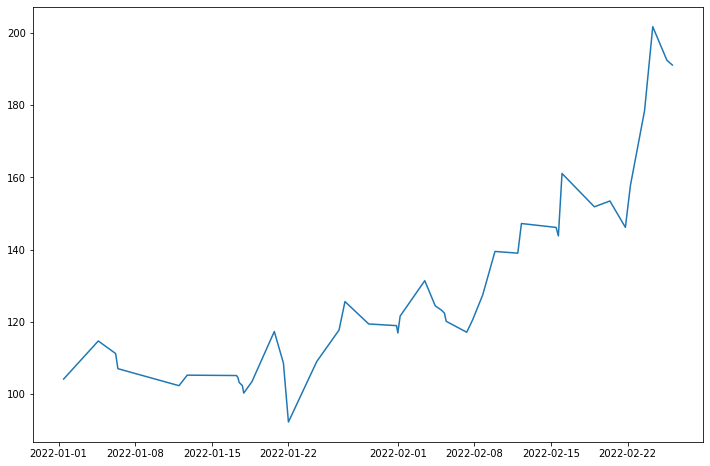

In [226]:
plt.figure(figsize=(12,8))
plt.plot(result.sort_values('entry_date').account_size)

In [52]:
def get_best_param(df_input):
    rsi_range = np.arange(2, 3)
    ema_range = np.arange(2, 5)

    trader = Trader(leverage=1, margin=1, fixed_margin=False)
    
    best_percentage = 0
    best_param = None

    for i, r in enumerate(rsi_range):
        print('\rr={:d} | {:.2f}%'.format(r, i / (len(rsi_range) + 1) * 100), end='')
        for e in ema_range:
            

            df = df_input.copy()
            df = df.assign(rsi=talib.RSI(df.Close, timeperiod=r))
            df = df.assign(rsi_ema=talib.SMA(df.rsi, timeperiod=e))
            df = df.dropna()

            if len(df) < 5:
                continue

            trader.reset()

            previous_rsi = df.iloc[0].rsi
            previous_rsiema = df.iloc[0].rsi_ema
            for idx, data in df.iloc[1:].iterrows():
                if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
                    if trader.position != None:
                        trader.close_pos(data.Close, exit_date=idx,
                                         exit_rsi = data.rsi,
                                         exit_rsiema = data.rsi_ema,
                                         exit_previous_rsi = previous_rsi,
                                         exit_previous_rsiema = previous_rsiema)
                        trader.open_pos(data.Close, 'long', 
                                        entry_date = idx,
                                        entry_rsi = data.rsi,
                                        entry_rsiema = data.rsi_ema,
                                        entry_previous_rsi = previous_rsi,
                                        entry_previous_rsiema = previous_rsiema)
                    else:
                        trader.open_pos(data.Close, 'long', 
                                        entry_date = idx,
                                        entry_rsi = data.rsi,
                                        entry_rsiema = data.rsi_ema,
                                        entry_previous_rsi = previous_rsi,
                                        entry_previous_rsiema = previous_rsiema)
                elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
                    if trader.position != None:
                        trader.close_pos(data.Close, exit_date=idx,
                                         exit_rsi = data.rsi,
                                         exit_rsiema = data.rsi_ema,
                                         exit_previous_rsi = previous_rsi,
                                         exit_previous_rsiema = previous_rsiema)
                        trader.open_pos(data.Close, 'short', 
                                        entry_date = idx,
                                        entry_rsi = data.rsi,
                                        entry_rsiema = data.rsi_ema,
                                        entry_previous_rsi = previous_rsi,
                                        entry_previous_rsiema = previous_rsiema)
                    else:
                        trader.open_pos(data.Close, 'short', 
                                        entry_date = idx,
                                        entry_rsi = data.rsi,
                                        entry_rsiema = data.rsi_ema,
                                        entry_previous_rsi = previous_rsi,
                                        entry_previous_rsiema = previous_rsiema)

                previous_rsi = data.rsi
                previous_rsiema = data.rsi_ema
                if trader.position != None:
                    if trader.is_liquidated(data.Close):
                        print('liquidated')
                        break
                
                if trader.account_size > best_percentage:
                    best_percentage = trader.account_size
                    best_param = (r, e)
                    
    return best_param

1. Load data (1st month for RSI calculation, other months for testing)
2. define start date
2. Compute best initial rsi and sma
    - use [start date - 30, start date]
3. 

In [62]:
trader = Trader(leverage=1, margin=1, fixed_margin=False)
current_date = datetime.datetime(2022, 3, 1)

data_paths = [
    'data/2022/january/ethusdt.1hour.1january2022-1february2022.csv',
    'data/2022/february/ethusdt.1hour.1-28feb2022.csv',
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')
df.index = pd.to_datetime(df.index)

df_tmp = df.copy()

df_tmp.index = pd.to_datetime(df_tmp.index)
df_tmp = df_tmp.sort_values('Open time')

initial_r, initial_s = get_best_param(df_tmp[(df_tmp.index >= current_date - datetime.timedelta(days=30)) & (df_tmp.index < current_date)])
df_tmp = df_tmp.assign(rsi=talib.RSI(df_tmp.Close, timeperiod=initial_r))
df_tmp = df_tmp.assign(rsi_ema=talib.SMA(df_tmp.rsi, timeperiod=initial_s))
df_tmp = df_tmp.dropna()

dates = df.index

previous_rsi = df_tmp.rsi
previous_rsiema = df_tmp.rsi_ema

r=2 | 0.00%

In [55]:
str(current_date)

'2022-03-01 00:00:00'

In [68]:
df.iloc[(np.where(dates == current_date)[0][0]) - 1]

Open        2896.640
High        2924.760
Low         2891.500
Close       2920.100
Volume    115766.948
Name: 2022-02-28 23:00:00, dtype: float64

In [69]:
df[df.index.month == 2]

,Open,High,Low,Close,Volume
Open time,,,,,
2022-02-01 00:00:00,2685.34,2705.53,2672.61,2687.34,75617.393
2022-02-01 01:00:00,2687.35,2701.66,2677.07,2683.27,51590.707
2022-02-01 02:00:00,2683.35,2720.00,2679.03,2714.04,53530.192
2022-02-01 03:00:00,2714.04,2758.28,2708.25,2749.50,102842.262
2022-02-01 04:00:00,2749.49,2765.99,2732.69,2741.97,61793.786
...,...,...,...,...,...
2022-02-28 19:00:00,2807.39,2809.71,2790.06,2807.36,58162.077
2022-02-28 20:00:00,2807.36,2838.99,2794.77,2833.03,131382.838
2022-02-28 21:00:00,2833.04,2833.51,2807.66,2819.18,47349.042


In [61]:
df.loc[str(current_date)]

Open        2920.050
High        2974.440
Low         2919.030
Close       2947.440
Volume    186530.975
Name: 2022-03-01 00:00:00, dtype: float64

In [57]:
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-02-28 15:00:00', '2022-02-28 16:00:00',
               '2022-02-28 17:00:00', '2022-02-28 18:00:00',
               '2022-02-28 19:00:00', '2022-02-28 20:00:00',
               '2022-02-28 21:00:00', '2022-02-28 22:00:00',
               '2022-02-28 23:00:00', '2022-03-01 00:00:00'],
              dtype='datetime64[ns]', name='Open time', length=1417, freq=None)

In [45]:
df[df.index == str(current_date)]

,Open,High,Low,Close,Volume
Open time,,,,,
2022-03-01 00:00:00,2920.05,2974.44,2919.03,2947.44,186530.975


In [4]:
for idx, date in dates[1:]:
    df_tmp = df.copy()

    df_tmp.index = pd.to_datetime(df_tmp.index)
    df_tmp = df_tmp.sort_values('Open time')

    initial_r, initial_s = get_best_param(df[(df.index >= current_date - datetime.timedelta(days=30)) & (df.index < current_date)])
    df_tmp = df_tmp.assign(rsi=talib.RSI(df_tmp.Close, timeperiod=initial_r))
    df_tmp = df_tmp.assign(rsi_ema=talib.SMA(df_tmp.rsi, timeperiod=initial_s))
    df_tmp = df_tmp.dropna()
    
    previous_rsi = df_tmp.iloc[0].rsi
    previous_rsiema = df_tmp.iloc[0].rsi_ema

    if (previous_rsi < previous_rsiema) & (data.rsi > data.rsi_ema): # long
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'long', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
    elif (previous_rsi > previous_rsiema) & (data.rsi < data.rsi_ema): # short
        if trader.position != None:
            trader.close_pos(data.Close, exit_date=idx,
                             exit_rsi = data.rsi,
                             exit_rsiema = data.rsi_ema,
                             exit_previous_rsi = previous_rsi,
                             exit_previous_rsiema = previous_rsiema)
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
        else:
            trader.open_pos(data.Close, 'short', 
                            entry_date = idx,
                            entry_rsi = data.rsi,
                            entry_rsiema = data.rsi_ema,
                            entry_previous_rsi = previous_rsi,
                            entry_previous_rsiema = previous_rsiema)
    
    if trader.position != None:
        if trader.is_liquidated(data.Close):
            print('liquidated')
            break
    
    current_date = current_date  + datetime.timedelta(days=1)
    previous_rsi = data.rsi
    previous_rsiema = data.rsi_ema

In [5]:
df[df.index < datetime.datetime(2022, 3, 20) - datetime.timedelta(days=10)]

,Open,High,Low,Close,Volume,rsi,rsi_ema
Open time,,,,,,,
2022-02-01 00:00:00,2685.34,2705.53,2672.61,2687.34,75617.393,61.267225,54.257450
2022-02-01 01:00:00,2687.35,2701.66,2677.07,2683.27,51590.707,60.726005,54.362889
2022-02-01 02:00:00,2683.35,2720.00,2679.03,2714.04,53530.192,63.261379,54.498361
2022-02-01 03:00:00,2714.04,2758.28,2708.25,2749.50,102842.262,65.884063,54.672592
2022-02-01 04:00:00,2749.49,2765.99,2732.69,2741.97,61793.786,64.867932,54.819534
...,...,...,...,...,...,...,...
2022-03-09 19:00:00,2710.11,2719.73,2677.33,2713.26,94761.648,57.444150,53.333142
2022-03-09 20:00:00,2713.27,2726.96,2678.53,2686.82,59233.741,54.311747,53.658338
2022-03-09 21:00:00,2686.81,2712.40,2681.06,2706.69,49687.571,56.167847,53.952768


In [6]:
a = df[df.index < datetime.datetime(2022, 3, 20) - datetime.timedelta(days=10)]